In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from pandas_datareader import data as pdr
from fastai.tabular.core import add_datepart
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV

[*********************100%***********************]  1 of 1 completed


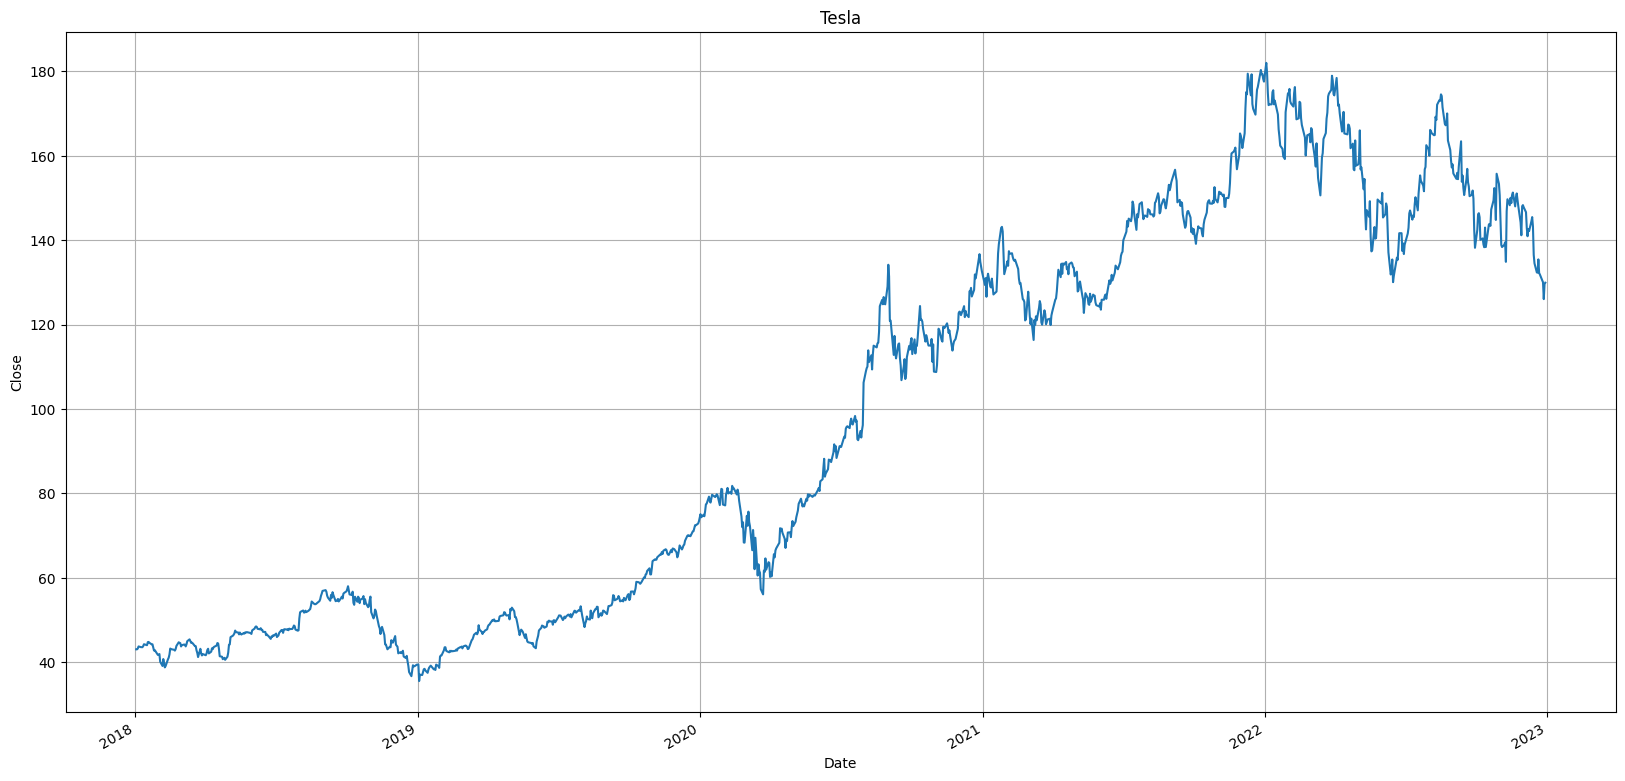

In [18]:
# Set the API parameters
tickers = ['AAPL', 'MSFT', '^GSPC']
date_end = '2023-01-01' # period start date
date_start = '2018-01-01' # period end date
company_symbol = "PG" # asset symbol - For more symbols check yahoo.finance.com

# Send the request to the yahoo finance api endpoint
yf.pdr_override() # <== that's all it takes :-)

df = pdr.get_data_yahoo(tickers[0], start=date_start, end=date_end)
df.head(5)
# df.describe()
close = df['Close']
ax = close.plot(title='Tesla')
ax.set_xlabel('Date')
ax.set_ylabel('Close')
ax.grid()
plt.show()

In [19]:

df = df.reset_index()

# Convert Date to Timeseries
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#sorting
data = df.sort_index(ascending=True, axis=0)

#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]
new_data['mon_fri'] = 0
add_datepart(new_data, 'Date')
new_data.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp


train = new_data[:1200]
valid = new_data[1200:]

x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']

# print(x_valid, y_valid, x_train, y_train)

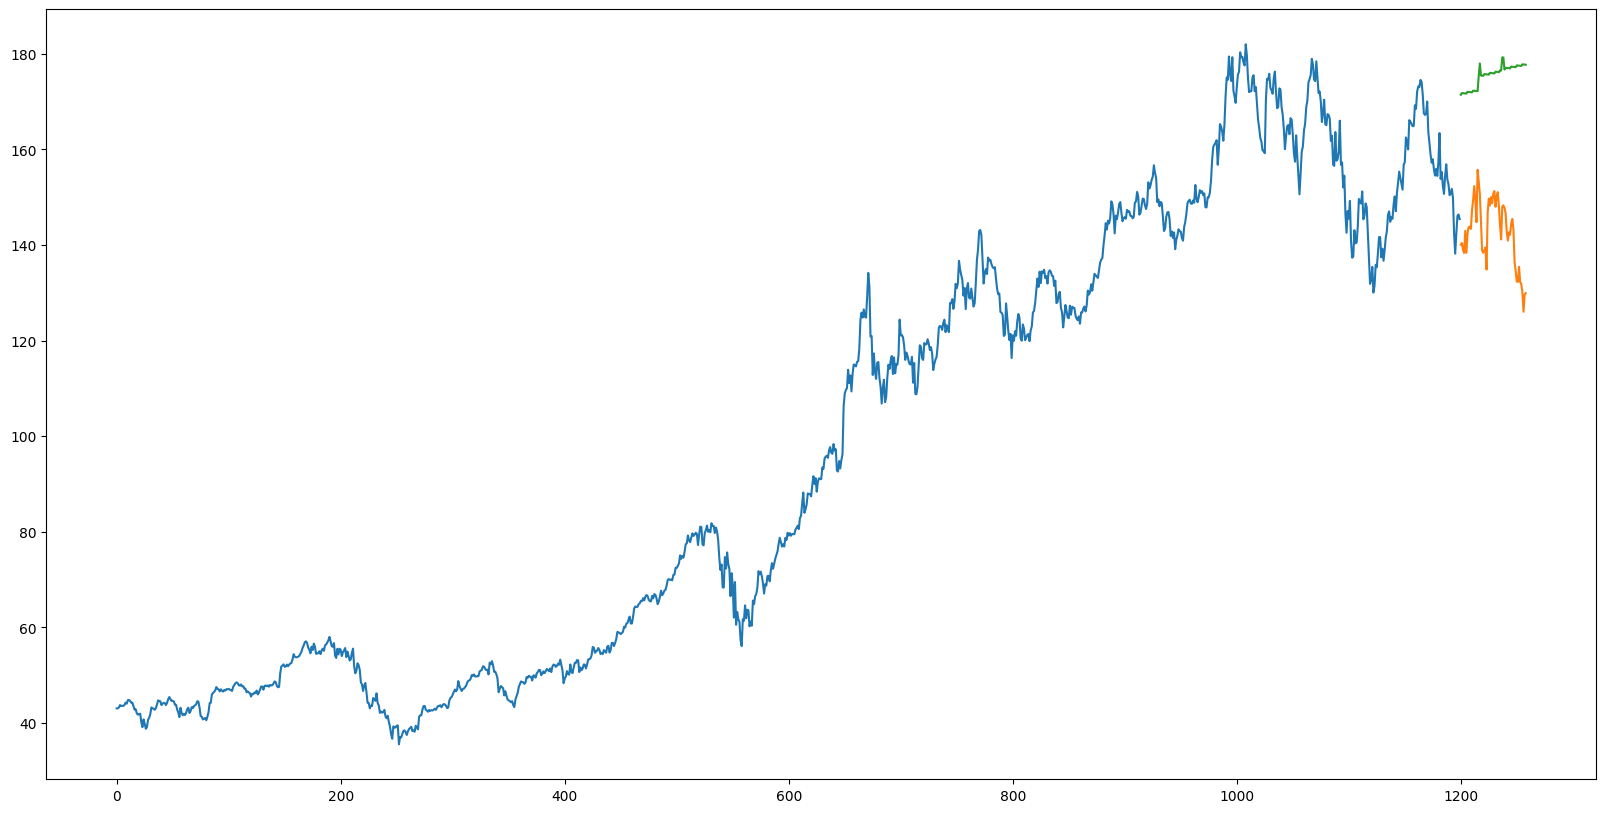

In [22]:

#Implement linear regression
model = LinearRegression()
model.fit(x_train,y_train)

#Make predictions and find the rmse
preds = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
# print(rms, preds)

# need yo resolve below error
# valid['Predictions'] = preds
# valid.loc[:, 'Predictions'] = preds
# valid.at[:, 'Predictions'] = preds
valid_copy = valid.copy()
valid_copy.loc[:, 'Predictions'] = preds


valid.index = new_data[1200:].index
train.index = new_data[:1200].index

plt.plot(train['Close'])
plt.plot(valid_copy[['Close', 'Predictions']])



96.57803270309866


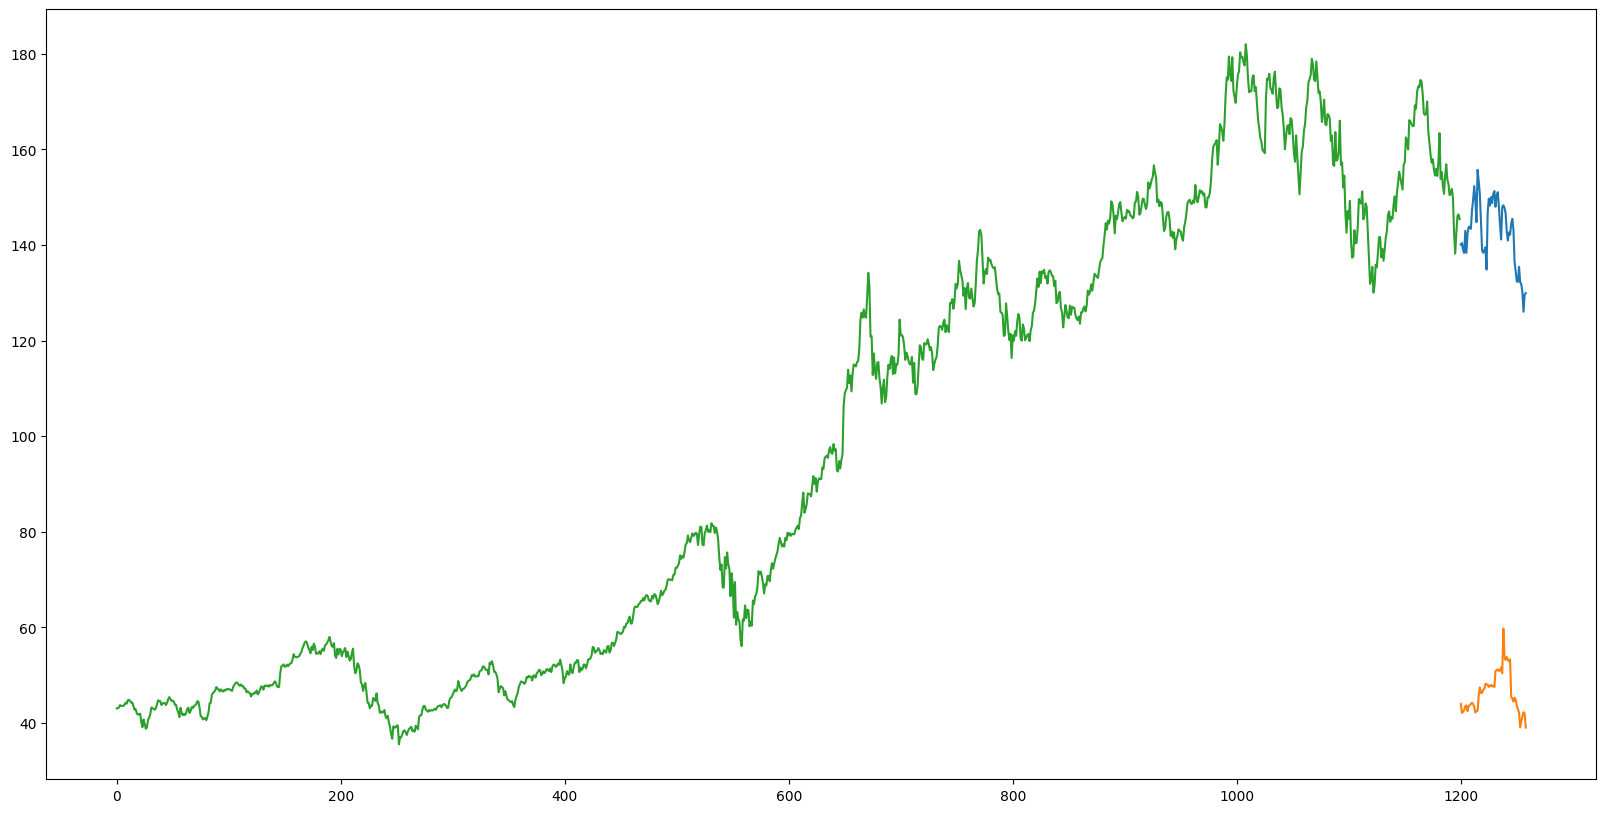

In [24]:
#KNN Model
scaler = MinMaxScaler(feature_range=(0, 1))

#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_valid)
#rms
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
print(rms)
# valid['Predictions'] = 0
# valid['Predictions'] = preds
valid_copy = valid.copy()
valid_copy.loc[:, 'Predictions'] = preds
plt.plot(valid_copy[['Close', 'Predictions']])
plt.plot(train['Close'])


1140/1140 - 20s - loss: 0.0027 - 20s/epoch - 18ms/step
2/2 [==============================] - 1s 12ms/step
7.198198830319953


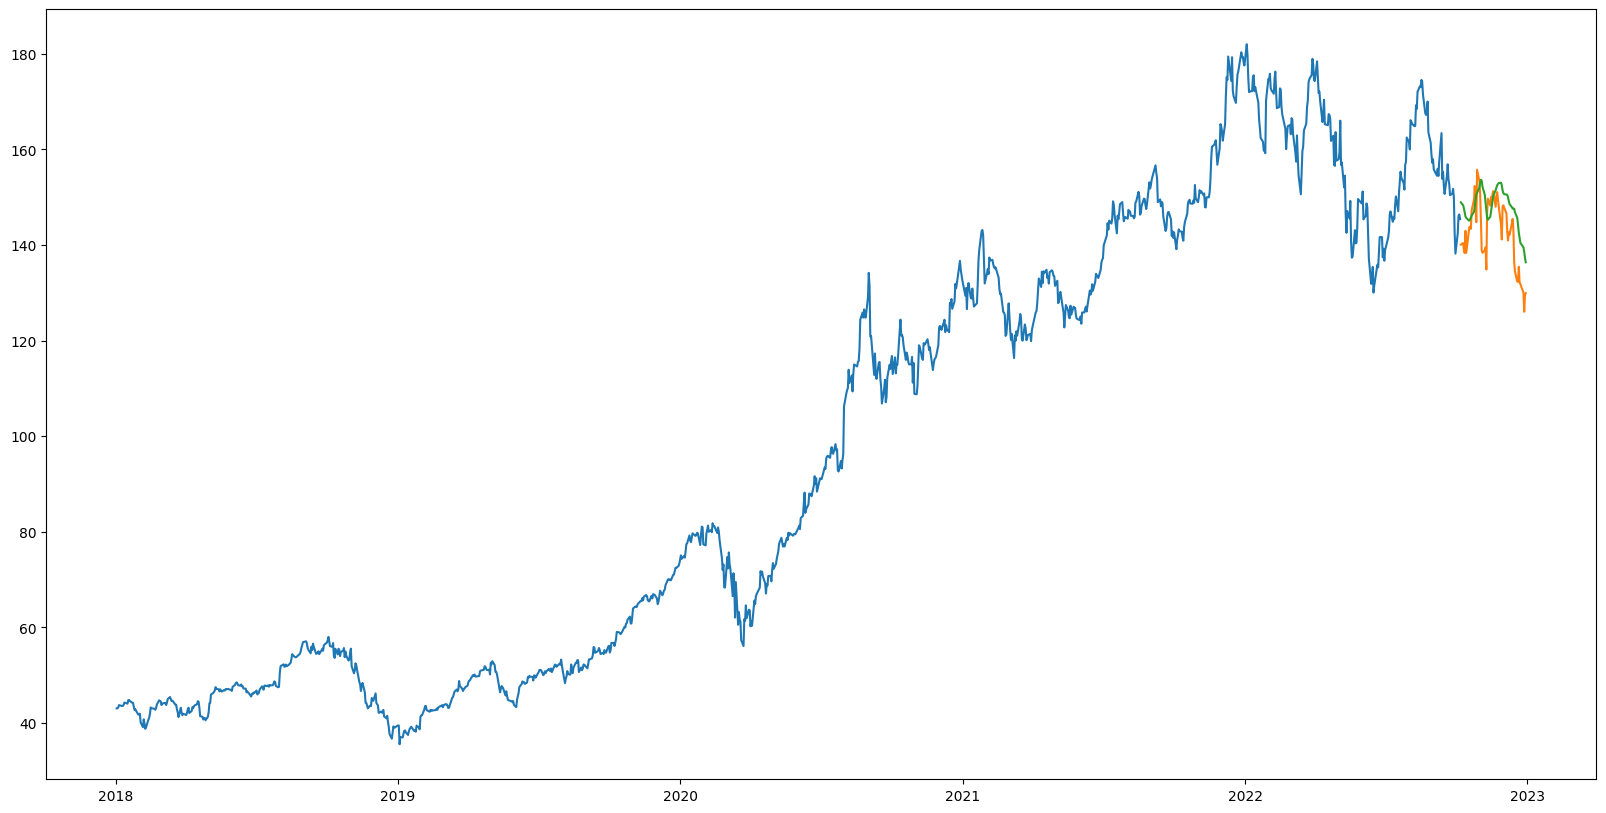

In [25]:
#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:1200,:]
valid = dataset[1200:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

#rms
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
print(rms)

#plot
train = new_data[:1200]
valid = new_data[1200:]
# valid['Predictions'] = closing_price
valid_copy = valid.copy()
valid_copy.loc[:, 'Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid_copy[['Close','Predictions']])
plt.show()